# Task Description

**Context**

Have you ever wondered when the best time of year to book a hotel room is? Or the optimal length of stay in order to get the best daily rate? What if you wanted to predict whether or not a hotel was likely to receive a disproportionately high number of special requests?

This hotel booking dataset can help you explore those questions!

**Content**

This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

# Data

In [ ]:
!pip install sklearn_evaluation
!pip install xgboost
!pip install interpret
!pip install lime
!pip install shap

In [295]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn_evaluation import plot
import graphviz 
from IPython import display
from sklearn import tree
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from interpret.blackbox import LimeTabular
from interpret import show
import lime
from lime import lime_tabular
import shap

In [153]:
df = pd.read_csv('hotel_bookings.csv')
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       2  ...    No Deposit   
1                        0                     0       2  ...    No Deposit   
2                        0                     1       1  ...    No Deposit   
3                        0                     1       1  ...    No Deposit   
4                        0                     2       2  ...    No Deposit   

   agent company days_in_waiting_list customer_type   adr  \
0    NaN     NaN                    0     Transient   0.0   
1    NaN     NaN                    0     Transient   0.0   
2    NaN     NaN                    0     Transient  75.0   
3  304.0     NaN                    0     Transient  75.0   
4  240.0     NaN                    0     Transient  98.0   

   required_car_parking_spaces  total_of_special_requests  reservation_status  \
0                            0                          0           Check-Out   
1                            0                          0           Check-Out   
2                            0                          0           Check-Out   
3                            0                          0           Check-Out   
4                            0                          1           Check-Out   

  reservation_status_date  
0              2015-07-01  
1              2015-07-01  
2              2015-07-02  
3              2015-07-02  
4              2015-07-03  

[5 rows x 32 columns]

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [155]:
filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
df = df[~filter]

Categorical features

In [156]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
cat_cols

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [157]:
for col in df[cat_cols].columns:
    print(f"{col}: \n{df[col].unique()}\n")

hotel: 
['Resort Hotel' 'City Hotel']

arrival_date_month: 
['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']

meal: 
['BB' 'FB' 'HB' 'SC' 'Undefined']

country: 
['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' nan 'ROU' 'NOR' 'OMN' 'ARG' 'POL'
 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST'
 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR'
 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO'
 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM'
 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY'
 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN'
 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB'
 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI'
 'SAU' 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB'
 'NPL' 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA

Preprocessing of features

In [158]:
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

df['year'] = df['reservation_status_date'].dt.year
df['month'] = df['reservation_status_date'].dt.month
df['day'] = df['reservation_status_date'].dt.day
df.drop(['reservation_status_date','arrival_date_month', 'reservation_status'] , axis = 1, inplace = True)


In [159]:
# CANNOT in REAL LIFE
df.dropna(inplace=True)

<Axes: >

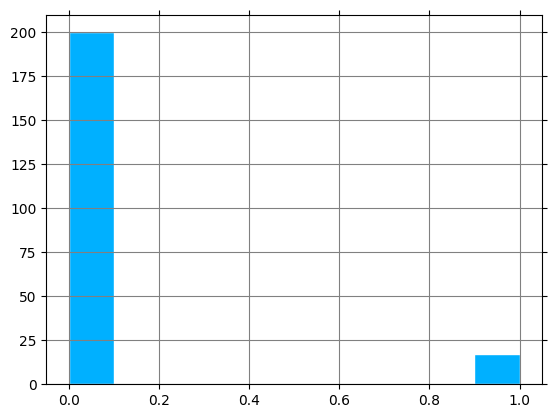

In [163]:
df['is_canceled'].hist()

In [164]:
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size = 0.30)

In [166]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) 
enc.fit(X_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [167]:
X_train = enc.transform(X_train)
X_test = enc.transform(X_test)

# Building models

Our target variable - 'is_cancelled' \
We have binary classification here

## Decision Tree

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay


def fit_and_plot_classification(model, data, feature_names, target_names):
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    data[feature_names] = imp.fit_transform(data[feature_names])
    model.fit(data[feature_names], data[target_names])
    if data[target_names].nunique() == 2:
        palette = ["tab:red", "tab:blue"]
    else:
        palette = ["tab:red", "tab:blue", "black"]
    DecisionBoundaryDisplay.from_estimator(
        model,
        data[feature_names],
        response_method="predict",
        cmap="RdBu",
        alpha=0.5,
    )
    sns.scatterplot(
        data=data,
        x=feature_names[0],
        y=feature_names[1],
        hue=target_names,
        palette=palette,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")


def fit_and_plot_regression(model, data, feature_names, target_names):
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    data[feature_names] = imp.fit_transform(data[feature_names])
    model.fit(data[feature_names], data[target_names])
    data_test = pd.DataFrame(
        np.arange(data.iloc[:, 0].min(), data.iloc[:, 0].max()),
        columns=data[feature_names].columns,
    )
    target_predicted = model.predict(data_test)

    sns.scatterplot(
        x=data.iloc[:, 0], y=data[target_names], color="black", alpha=0.5
    )
    plt.plot(data_test.iloc[:, 0], target_predicted, linewidth=4)


data_clf_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_clf_column = "Species"
data_clf = pd.read_csv("penguins__classification.csv")


data_reg_columns = ["flipper_length_mm"]
target_reg_column = "body_mass_g"
data_reg = pd.read_csv("penguins_regression.csv")
data_reg.dropna(inplace=True)
data_reg.drop(columns=['species', 'island', 'culmen_length_mm', 'culmen_depth_mm', 'sex'], inplace=True)

### Input parameters:

* criterion - {“gini”, “entropy”, “log_loss”}, default=”gini”
* max_depth - the depth of a tree model (?)

* 
Controlls overall complexity, allows to get a trade-off between an under-fitted and over-fitted 

In [199]:
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

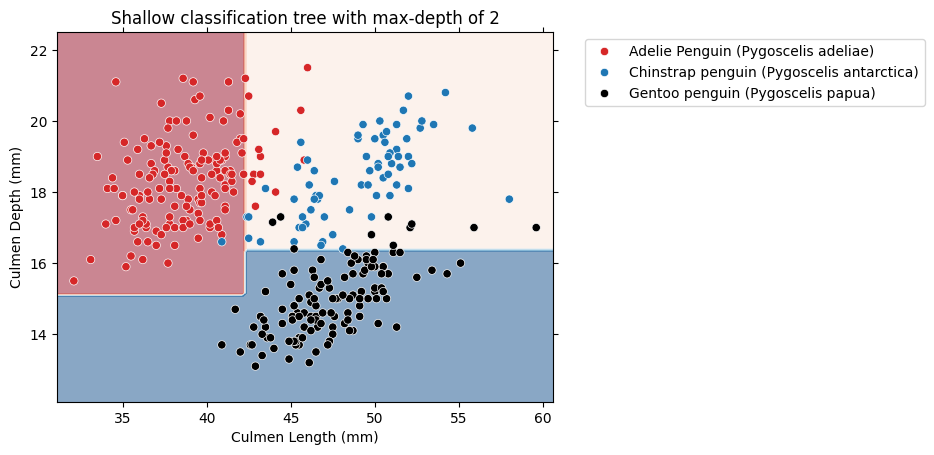

In [200]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column
)
_ = plt.title(f"Shallow classification tree with max-depth of {max_depth}")

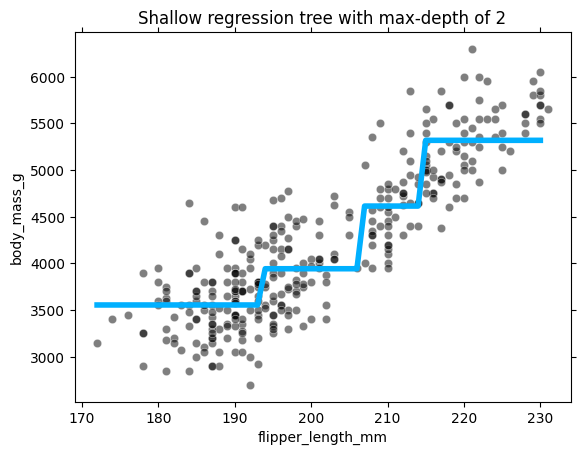

In [247]:
fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column
)
_ = plt.title(f"Shallow regression tree with max-depth of {max_depth}")

In [248]:
max_depth = 30
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_reg = DecisionTreeRegressor(max_depth=max_depth)

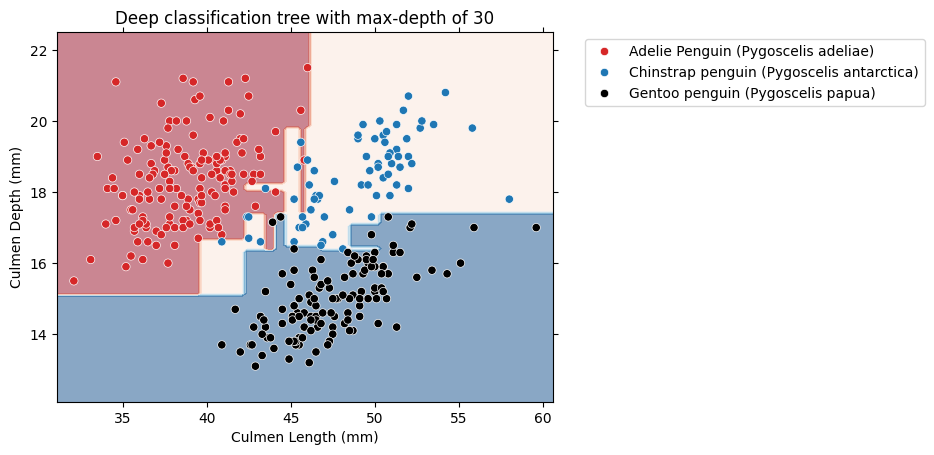

In [249]:
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column
)
_ = plt.title(f"Deep classification tree with max-depth of {max_depth}")

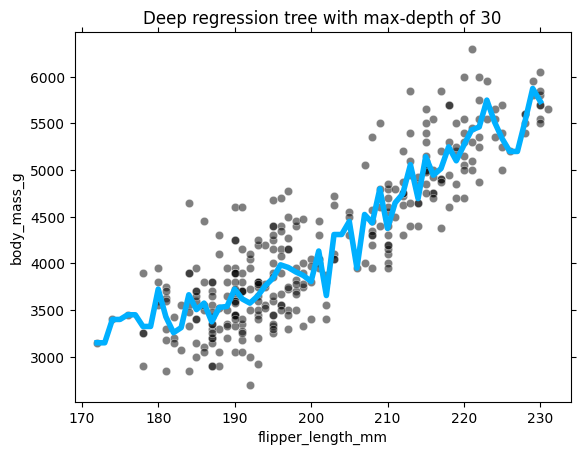

In [250]:
fit_and_plot_regression(
    tree_reg, data_reg, data_reg_columns, target_reg_column
)
_ = plt.title(f"Deep regression tree with max-depth of {max_depth}")

* min_samples_leaf - minimum number of samples required to be at a leaf node
* min_samples_split - The minimum number of samples required to split an internal node
* max_leaf_nodes - Grow trees with max_leaf_nodes in best-first fashion

* 
allow growing asymmetric trees and apply a constraint at the leaves or nodes level

In [257]:
from sklearn.datasets import make_blobs

data_clf_columns = ["Feature #0", "Feature #1"]
target_clf_column = "Class"

# Blobs that are interlaced
X_1, y_1 = make_blobs(
    n_samples=300, centers=[[0, 0], [-1, -1]], random_state=0
)
# Blobs that can be easily separated
X_2, y_2 = make_blobs(n_samples=300, centers=[[3, 6], [7, 0]], random_state=0)

X = np.concatenate([X_1, X_2], axis=0)
y = np.concatenate([y_1, y_2])
data_clf = np.concatenate([X, y[:, np.newaxis]], axis=1)
data_clf = pd.DataFrame(
    data_clf, columns=data_clf_columns + [target_clf_column]
)
data_clf[target_clf_column] = data_clf[target_clf_column].astype(np.int32)

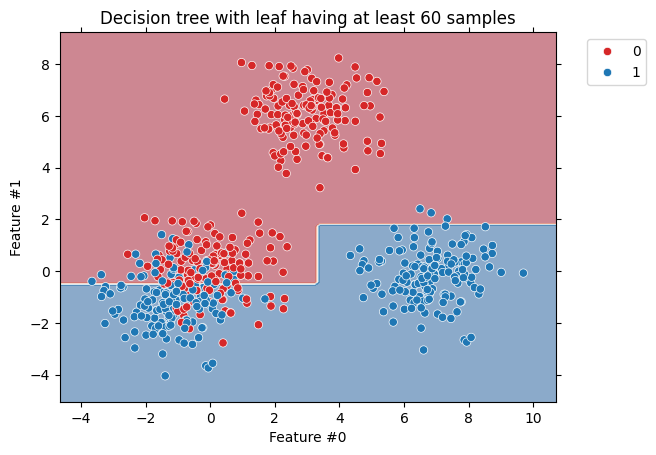

In [258]:
min_samples_leaf = 60
tree_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
fit_and_plot_classification(
    tree_clf, data_clf, data_clf_columns, target_clf_column
)
_ = plt.title(
    f"Decision tree with leaf having at least {min_samples_leaf} samples"
)

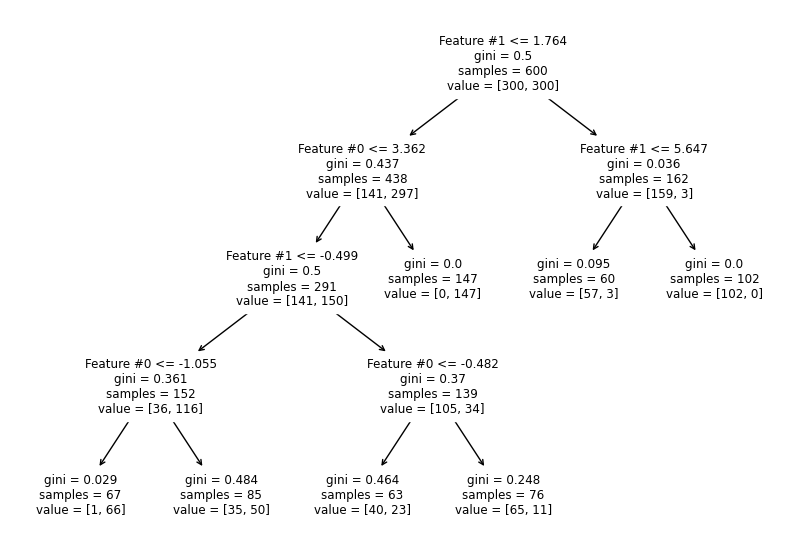

In [259]:
_, ax = plt.subplots(figsize=(10, 7))
_ = plot_tree(tree_clf, ax=ax, feature_names=data_clf_columns)

In [260]:
clf = DecisionTreeClassifier(max_depth = 4, random_state=0).fit(X_train, y_train)

In [169]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Model accuracy score with criterion entropy index: {acc}')


Model accuracy score with criterion entropy index: 0.9090909090909091


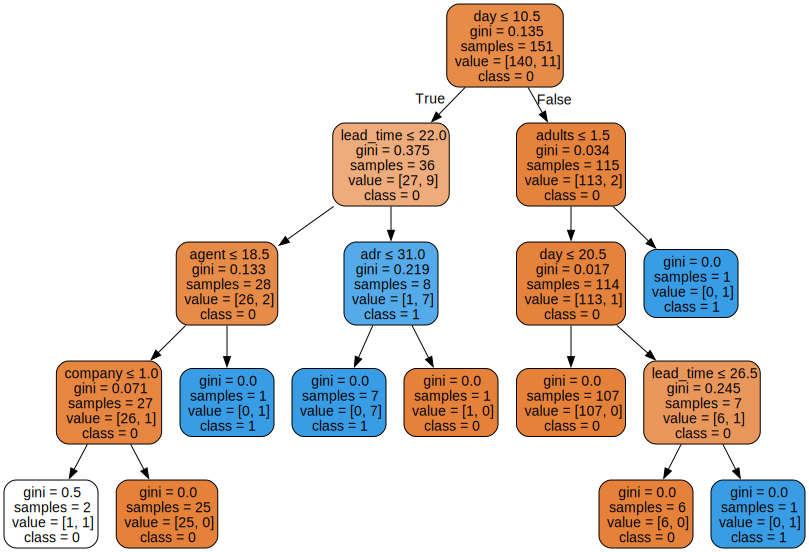

In [170]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                              feature_names=df.drop(columns='is_canceled').columns,  
                              class_names=['0', '1'],  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(dot_data) 
graph 

Deploy AI and data apps for free on Ploomber Cloud! Learn more: https://docs.cloud.ploomber.io/en/latest/quickstart/signup.html


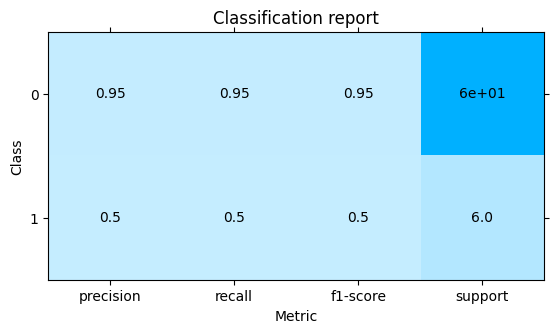

In [171]:
cr_dt = plot.ClassificationReport.from_raw_data(
    y_test, y_pred, target_names=['0', '1']
)

cr_dt

### Model weights

As we remember we have a very imbalanced dataset. You can notice it also in classification report

We can use parameter of model:
* class_weight

In [265]:
# define model
weights = {0:1.0, 1:100.0}
model = DecisionTreeClassifier(class_weight=weights, random_state=123)
model.fit(X_train, y_train)


DecisionTreeClassifier(class_weight={0: 1.0, 1: 100.0}, random_state=123)

In [266]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Model accuracy score with criterion entropy index: {acc}')

Model accuracy score with criterion entropy index: 0.9696969696969697


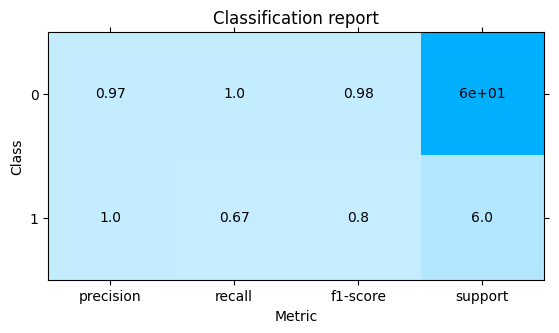

In [267]:
cr_dt = plot.ClassificationReport.from_raw_data(
    y_test, y_pred, target_names=['0', '1']
)

cr_dt

## Random Forest

### Input parameters

The same
*  criterion - {“gini”, “entropy”, “log_loss”}, default=”gini”
* max_depth
* min_samples_leaf
* e.t.c
New 
* n_estimators - (?)
* bootstrap  - Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.


In [275]:
clf_rf = RandomForestClassifier(max_depth= 4, class_weight=weights, random_state=123).fit(X_train, y_train)

In [276]:
y_pred_rf = clf_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred_rf)
print(f'Model accuracy score with criterion entropy index: {acc}')

Model accuracy score with criterion entropy index: 0.8787878787878788


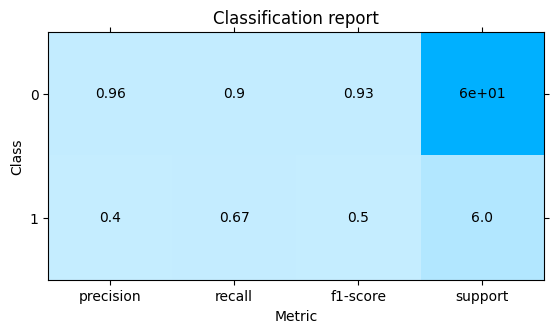

In [277]:
cr_rf = plot.ClassificationReport.from_raw_data(
    y_test, y_pred_rf, target_names=['0', '1']
)

cr_rf

## XGBoost

https://xgboost.readthedocs.io/en/stable/parameter.html


- **booster[default = gbtree]**

   - **booster** parameter helps us to choose which booster to use.
   - It helps us to select the type of model to run at each iteration. 
   - It has 3 options - **gbtree**, **gblinear** or **dart**.
   
       - **gbtree** and **dart** - use tree-based models, while
       - **gblinear** uses linear models. 

- **verbosity[default = 1]**

    - Verbosity of printing messages. 
    - Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug).
    

- **nthread [default = maximum number of threads available if not set]**

   - This is number of parallel threads used to run XGBoost.
   - This is used for parallel processing and number of cores in the system should be entered.
   - If you wish to run on all cores, value should not be entered and algorithm will detect automatically.
   

- **eta [default=0.3, alias: learning_rate]**

  - It is analogous to learning rate
  - It is the step size shrinkage used in update to prevent overfitting. 
  - After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
  - It makes the model more robust by shrinking the weights on each step.
  - range : [0,1]
  - Typical final values : 0.01-0.2.

- **max_depth [default=6]**

    - The maximum depth of a tree, same as GBM.
    - It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    - Increasing this value will make the model more complex and more likely to overfit. 
    - The value 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth. 
    - We should be careful when setting large value of max_depth because XGBoost aggressively consumes memory when training a deep tree.
    - range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist.
    - Should be tuned using CV.
    - Typical values: 3-10


- **tree_method string [default= auto]**

   - The tree construction algorithm used in XGBoost. 

   - XGBoost supports `approx`, `hist` and `gpu_hist` for distributed training. Experimental support for external memory is available for `approx` and `gpu_hist`.

   - Choices: `auto`, `exact`, `approx`, `hist`, `gpu_hist`

      - **auto**: Use heuristic to choose the fastest method.
         - For small to medium dataset, exact greedy (exact) will be used.

         - For very large dataset, approximate algorithm (approx) will be chosen.

         - Because old behavior is always use exact greedy in single machine, user will get a message when approximate algorithm is chosen to notify this choice.

     - **exact**: Exact greedy algorithm.

     - **approx**: Approximate greedy algorithm using quantile sketch and gradient histogram.

     - **hist**: Fast histogram optimized approximate greedy algorithm. It uses some performance improvements such as bins caching.

     - **gpu_hist**: GPU implementation of hist algorithm.

- **scale_pos_weight [default=1]**

     - It controls the balance of positive and negative weights, 
     - It is useful for imbalanced classes. 
     - A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
     - A typical value to consider: `sum(negative instances) / sum(positive instances)`.

**objective [default=reg:squarederror]**

- It defines the loss function to be minimized. Most commonly used values are given below -

     - **reg:squarederror** : regression with squared loss.
     
     - **reg:squaredlogerror**: regression with squared log loss 1/2[log(pred+1)−log(label+1)]2.               - All input labels are required to be greater than -1. 
     
     - **reg:logistic** : logistic regression
     
     - **binary:logistic** : logistic regression for binary classification, output probability
     
     - **binary:logitraw**: logistic regression for binary classification, output score before logistic transformation

     - **binary:hinge** : hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.
     
     - **multi:softmax** : set XGBoost to do multiclass classification using the softmax objective, you also need to set num_class(number of classes)

     - **multi:softprob** : same as softmax, but output a vector of ndata * nclass, which can be further reshaped to ndata * nclass matrix. The result contains predicted probability of each data point belonging to each class.    


**eval_metric [default according to objective]**


- The metric to be used for validation data.
- The default values are **rmse for regression**, **error for classification** and **mean average precision for ranking**.
- We can add multiple evaluation metrics.
- Python users must pass the metrices as list of parameters pairs instead of map.
- The most common values are given below -

   - **rmse** : [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
   - **mae** : [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error)
   - **logloss** : [negative log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood)
   - **error** : Binary classification error rate (0.5 threshold).  It is calculated as `#(wrong cases)/#(all cases)`. For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.
   - **merror** : Multiclass classification error rate. It is calculated as `#(wrong cases)/#(all cases)`.
   - **mlogloss** : [Multiclass logloss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html)
   - **auc**: [Area under the curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_curve)
   - **aucpr** : [Area under the PR curve](https://en.wikipedia.org/wiki/Precision_and_recall)

In [278]:
clf_xgb = XGBClassifier(scale_pos_weight=100).fit(X_train, y_train)

In [279]:
y_pred_xgb = clf_xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred_xgb)
print(f'Model accuracy score with criterion entropy index: {acc}')

Model accuracy score with criterion entropy index: 0.9090909090909091


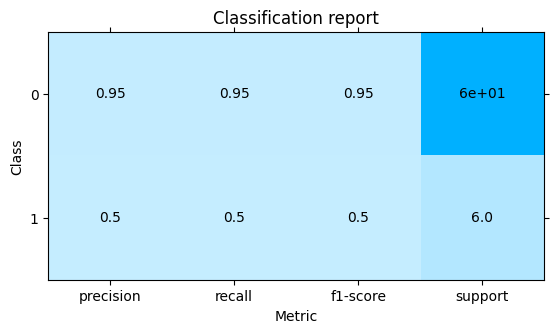

In [280]:
cr_xgb = plot.ClassificationReport.from_raw_data(
    y_test, y_pred_xgb, target_names=['0', '1']
)

cr_xgb

# Model's explainability

### Feature Importance

Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. ***The higher the value the more important the feature.***

<Axes: >

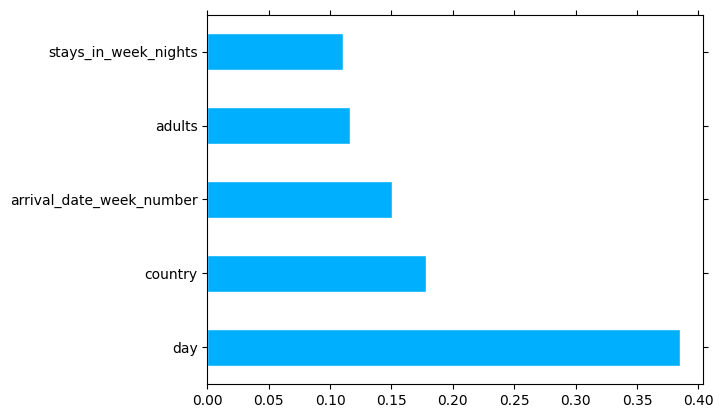

In [133]:
feat_importances = pd.Series(clf.feature_importances_, index=df.drop(columns=['is_canceled']).columns)
feat_importances.nlargest(5).plot(kind='barh')

## Lime

Local interpretable model-agnostic explanations


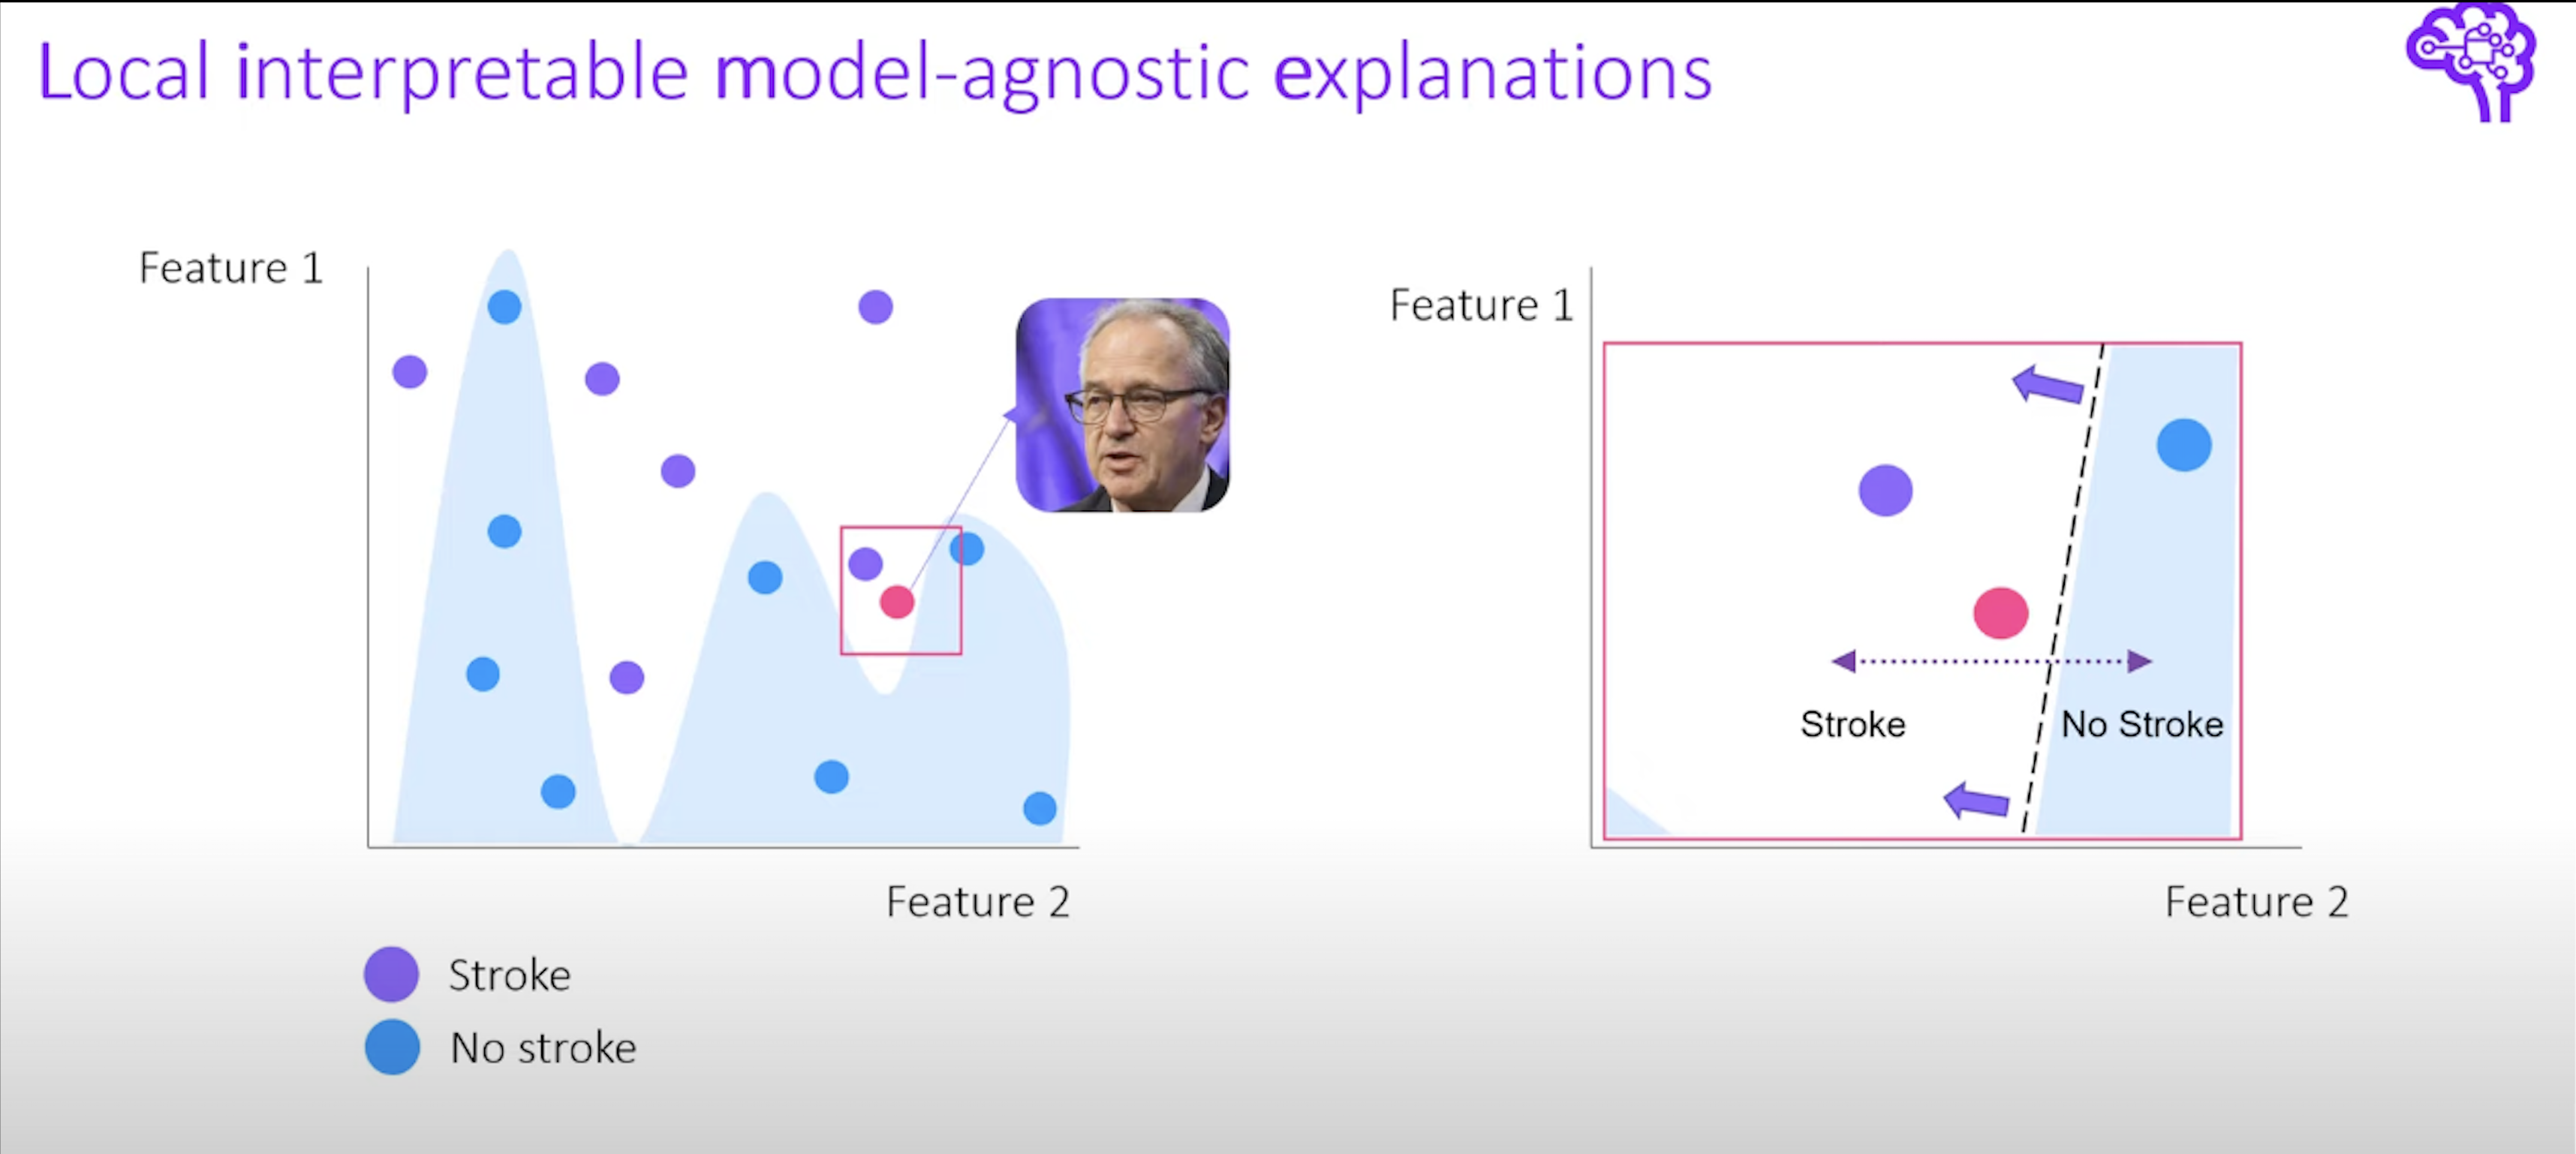

In [284]:
display.Image("data/lime_1.png")

Feature 2 here has an impact on a definition of class of the pink point, but feature 1 almost doesn’t have any influence in this case - we consider particular pink point - locally build simple model, which approximates the complex model exactly around this pink point

* Works on any blackbox model
* Models internals are ‘hidden’
* Works with many data types


Find approximation using following approach

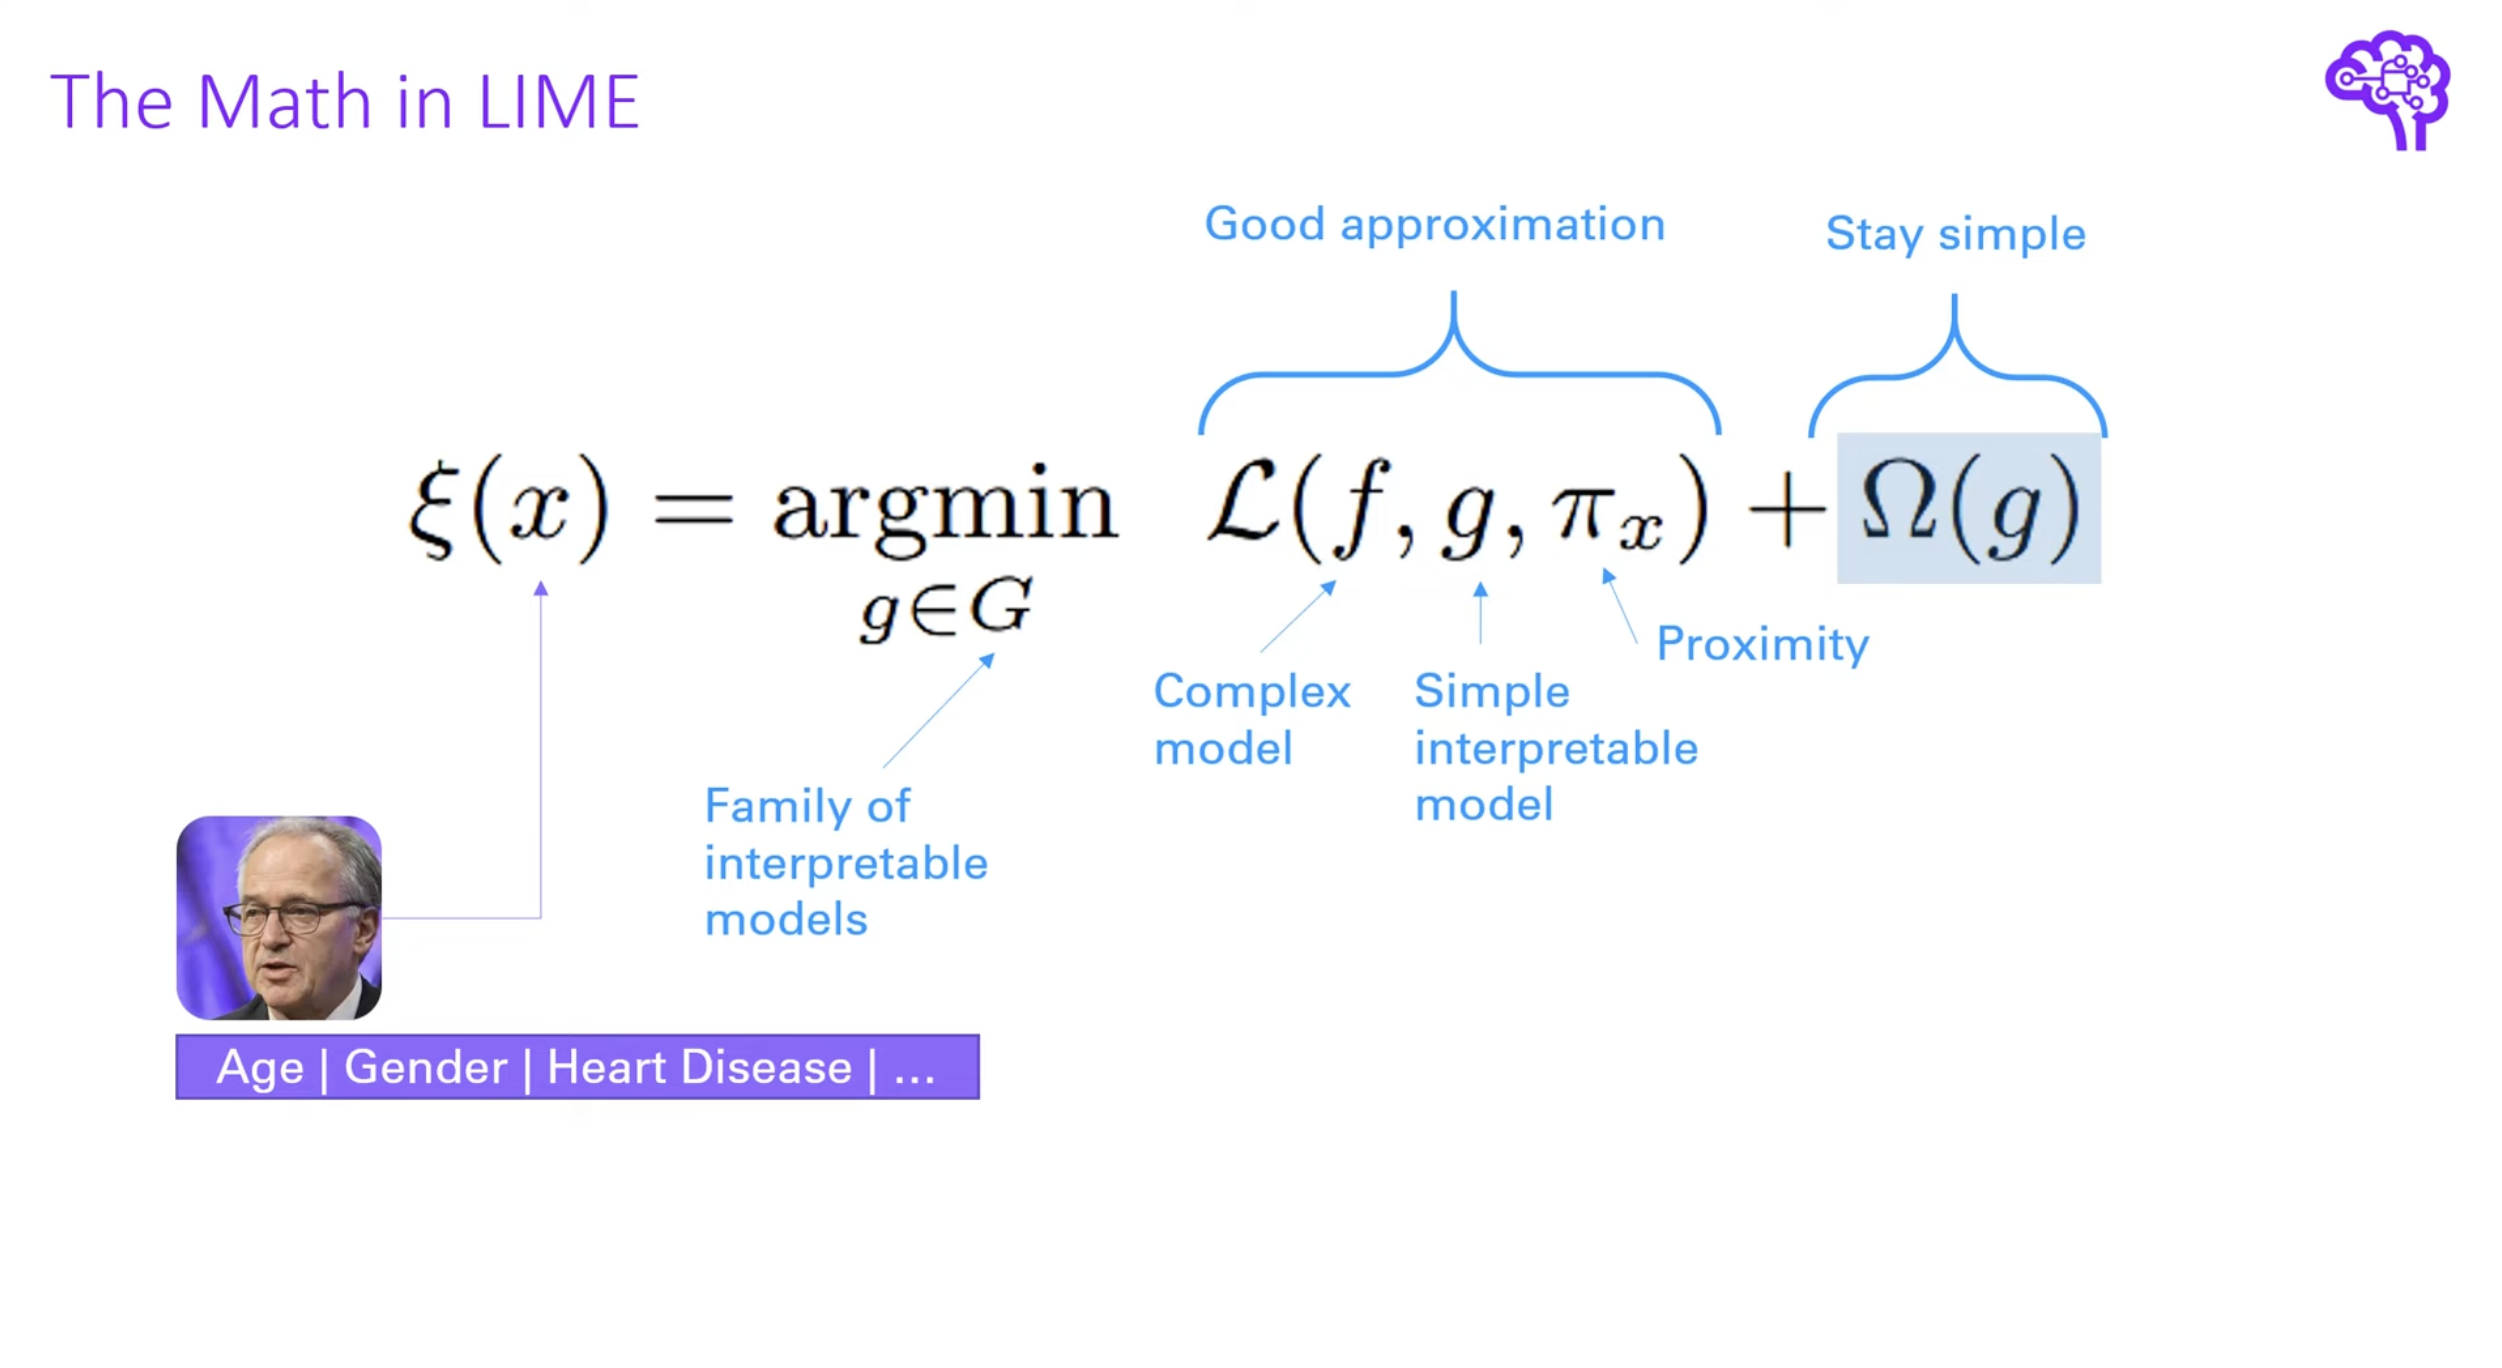

In [285]:
display.Image("data/lime_2.png")

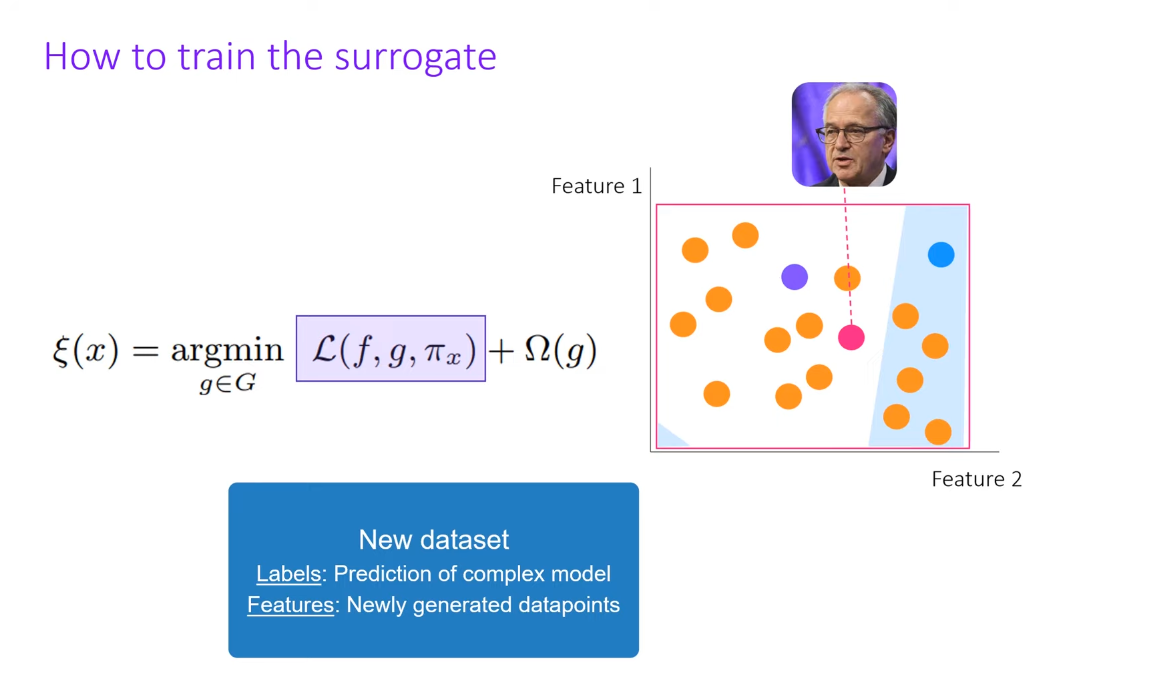

In [286]:
display.Image("data/lime_3.png")

In [287]:

predict_fn_rf = lambda x: clf_rf.predict_proba(x).astype(float)
X = X_train
explainer = lime_tabular.LimeTabularExplainer(X,feature_names = df.drop(columns='is_canceled').columns,class_names=['Not cancel','Will cancel'],kernel_width=5)

In [288]:
choosen_instance = X_test[12]
exp = explainer.explain_instance(choosen_instance, predict_fn_rf)
exp.show_in_notebook(show_all=False)

## SHAP

It comes from Game Theory. We have a coalition, we play a game and each participant will get a payout, but how can we share our common payout as a result of the game fairly between participants of the coalition?


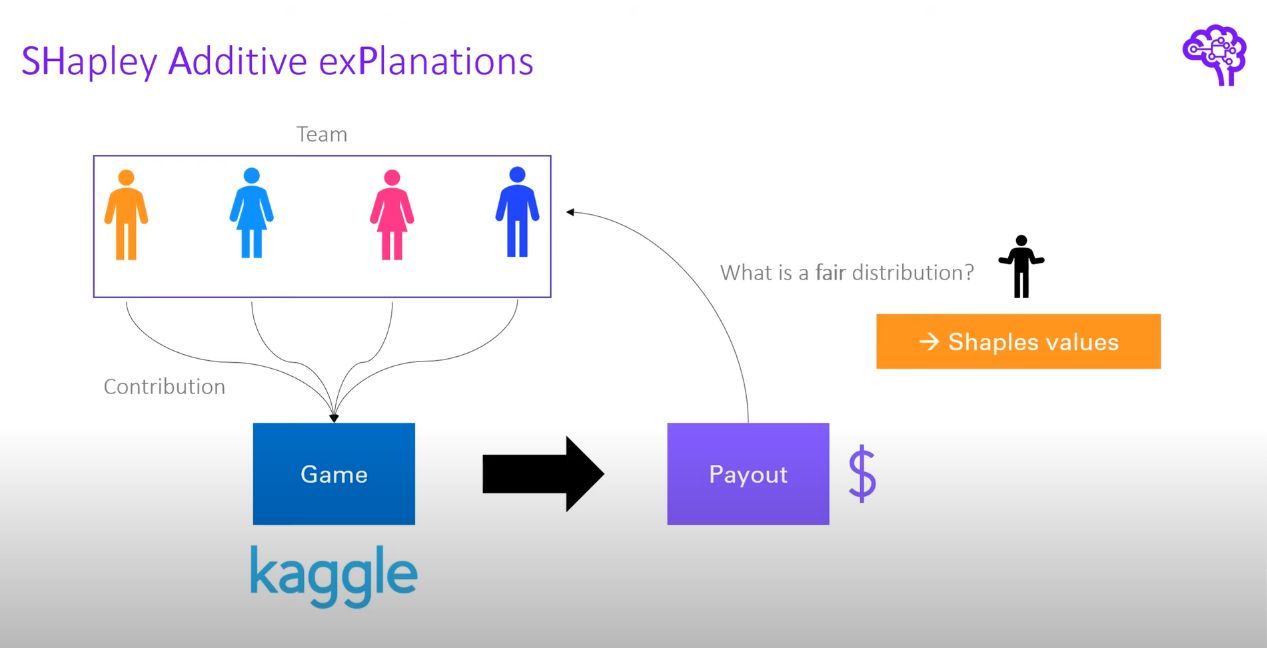

In [289]:
display.Image("data/shap_1.png")

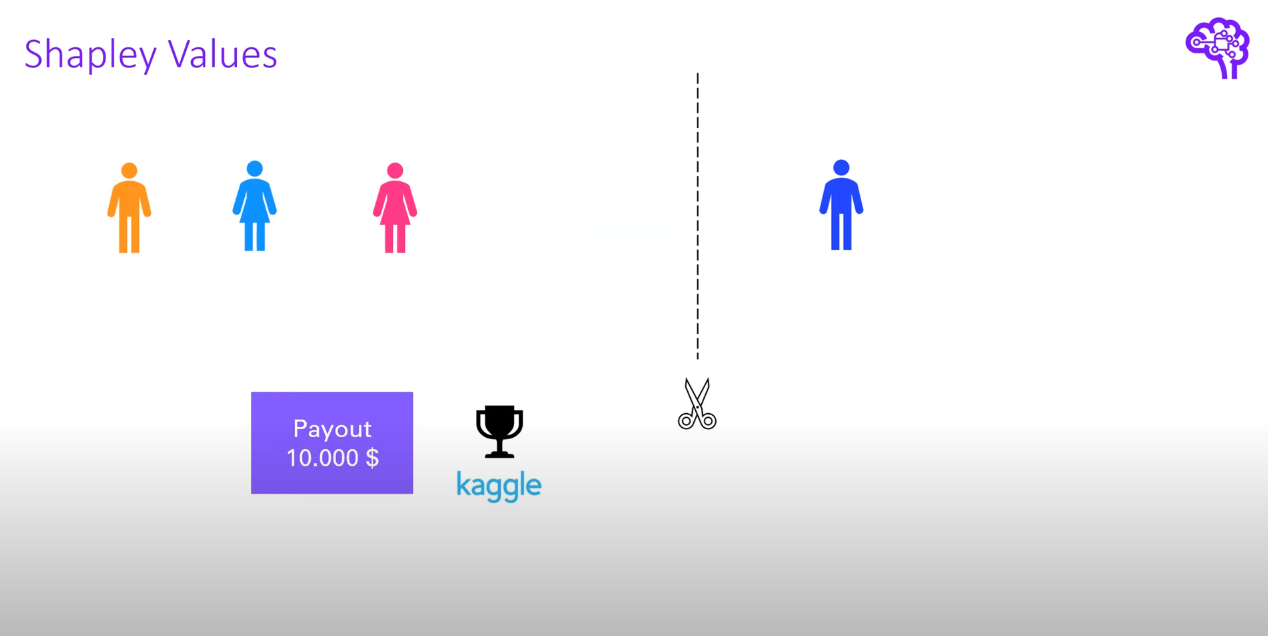

In [290]:
display.Image("data/shap_2.png")

***Shap main idea*** - calculate contribution in payout for each subset of players and then simply averaging over all of these contributions


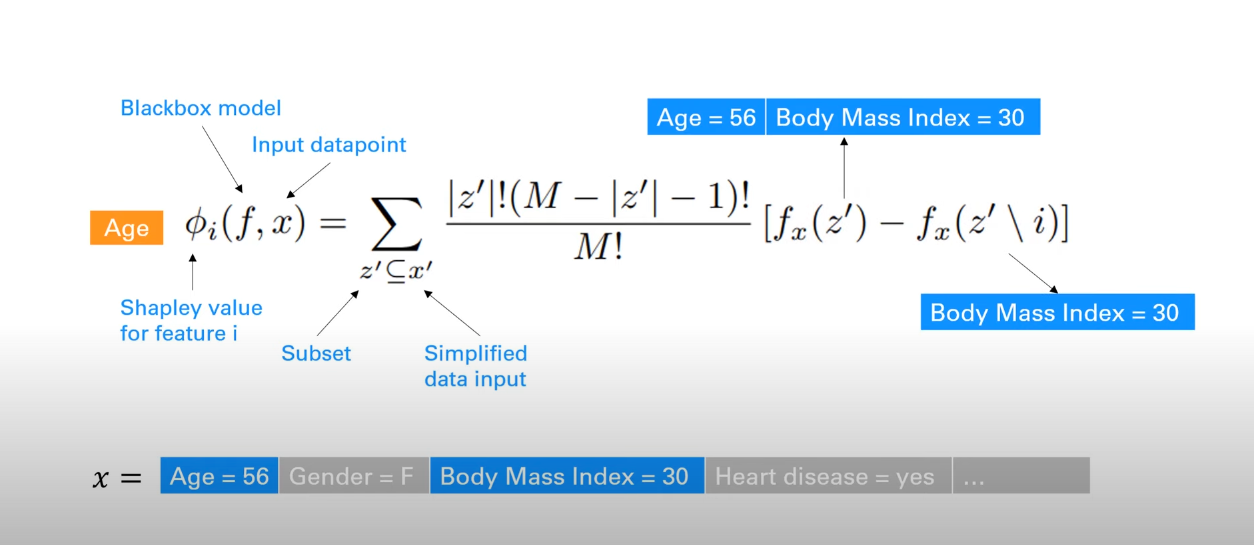

In [ ]:
display.Image("data/shap_3.png")

* |z’| - how many players(features) we have in that coalition(or in a subset)
* M - total number of features \
adding feature ‘Age’ should be weighted more if already many features were included into this subset. This tell us that this specific features gives us a string change in the prediction even if many other features are already included. 


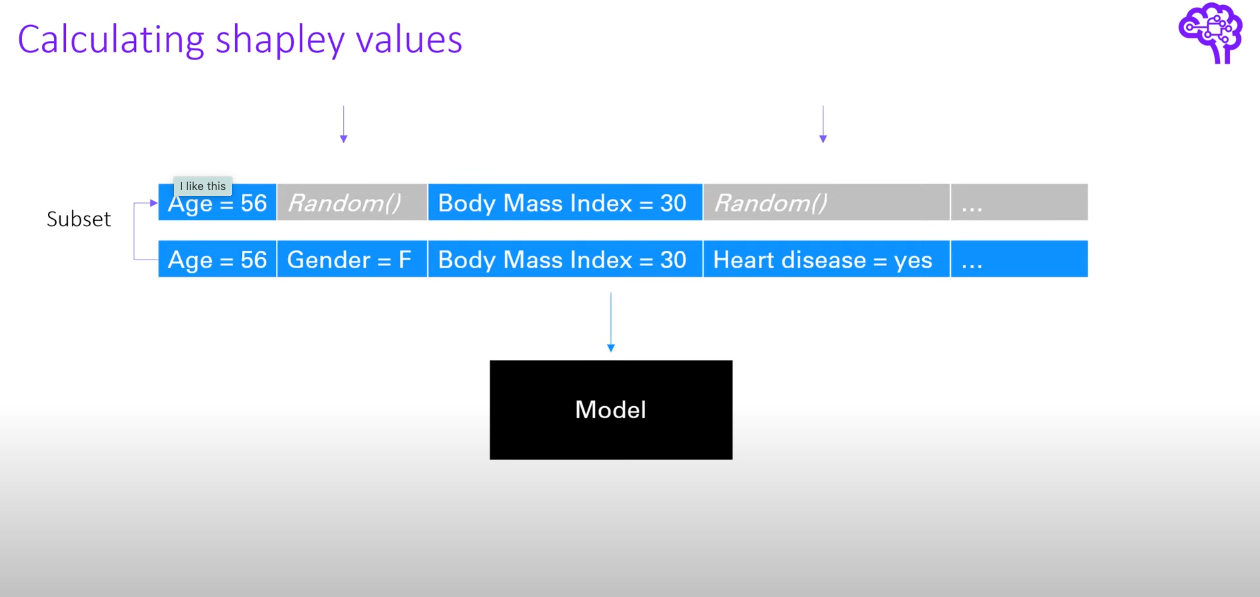

In [292]:
display.Image("data/shap_4.png")

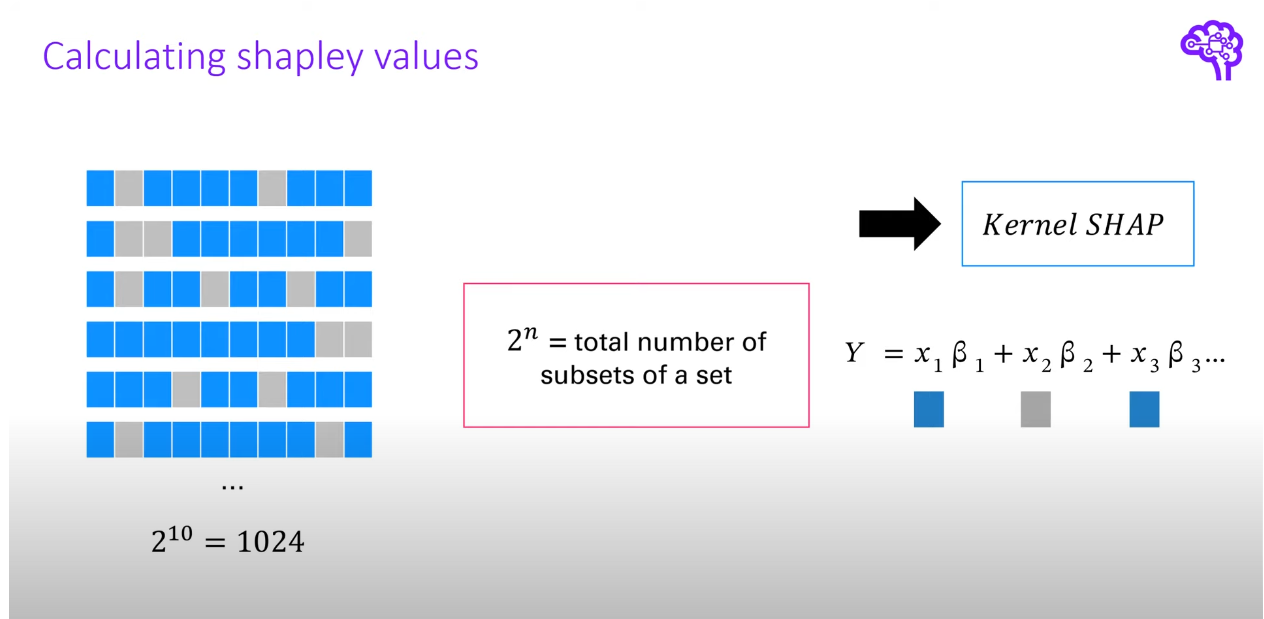

In [293]:
display.Image("data/shap_5.png")

In [297]:
# train a model with single tree
import xgboost
Xd = xgboost.DMatrix(X_train, label=y_train)
model = xgboost.train({"eta": 1, "max_depth": 3, "base_score": 0, "lambda": 0}, Xd, 1)

print("Model error =", np.linalg.norm(y_train - model.predict(Xd)))
print(model.get_dump(with_stats=True)[0])


pred = model.predict(Xd, output_margin=True)

explainer = shap.TreeExplainer(model)
explanation = explainer(Xd)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - pred).max()

Model error = 1.3491129752937
0:[f30<11] yes=1,no=2,missing=2,gain=1.48345816,cover=151
	1:[f1<22] yes=3,no=4,missing=4,gain=4.01785707,cover=36
		3:[f21<19] yes=7,no=8,missing=8,gain=0.894179881,cover=28
			7:leaf=0.0370370373,cover=27
			8:leaf=1,cover=1
		4:[f0<1] yes=9,no=10,missing=10,gain=0.875,cover=8
			9:leaf=-0,cover=1
			10:leaf=1,cover=7
	2:[f7<2] yes=5,no=6,missing=6,gain=0.973989308,cover=115
		5:[f30<21] yes=11,no=12,missing=12,gain=0.134085223,cover=114
			11:leaf=-0,cover=107
			12:leaf=0.142857149,cover=7
		6:leaf=1,cover=1



[14:08:45] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


1.1920929e-07

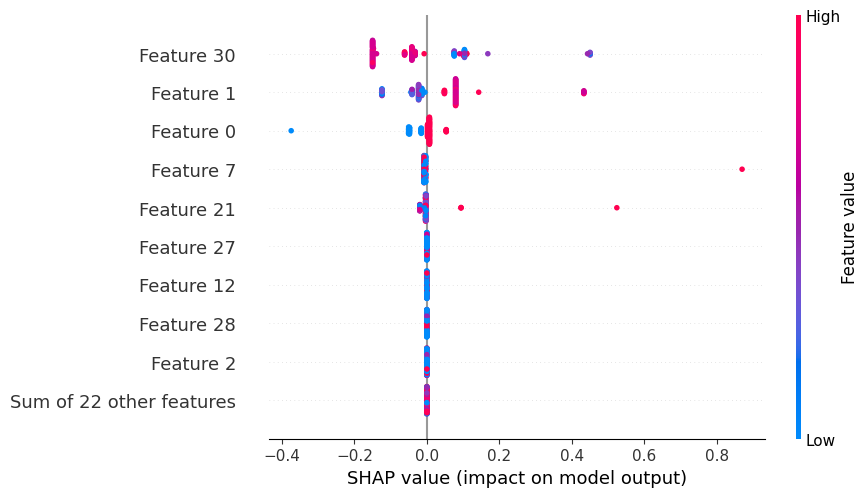

In [298]:
shap.plots.beeswarm(explanation)

### What is the difference between LIME and SHAP?

Challenges:
* missing values
* categorical features
* categorical features with high cardinality
* overfitting
* FEATURE ENGINEERING